# Import

In [ ]:
import torch
from torch import nn
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader
from fvcore.nn import FlopCountAnalysis, flop_count_table
import numpy as np
import matplotlib.pyplot as plt
import os
####################################################
from src.Mydataloader import LoadDataset
from src.Mymodel import Block
from src.Mymodel import MyResNet34
from src.Mymodel import MyResNet_CIFAR
from src.Mytraining import DoTraining

# Setup

In [ ]:
"""Dataset selection"""
DATASET = "CIFAR10"
# DATASET = "CIFAR100"
# DATASET = "ImageNet2012"

"""Model selection for CIFAR"""
NUM_LAYERS_LEVEL = 5

"""Dataset parameters"""
BATCH = 256
SHUFFLE = True
NUMOFWORKERS = 8
PIN_MEMORY = True
SPLIT_RATIO = 0
"""optimizer parameters"""
# OPTIMIZER = "SGD"
# OPTIMIZER = "Adam"
OPTIMIZER = "Adam_decay"

"""Learning rate scheduler parameters"""
LOAD_BEFORE_TRAINING = False
LOAD_BEFORE_TRAINING = True
NUM_EPOCHS = 5000

"""Early stopping parameters"""
EARLYSTOPPINGPATIENCE = 1200
file_path = ""
if DATASET == "ImageNet2012":
    file_path = f"{DATASET}/MyResNet34_{BATCH}_{OPTIMIZER}"
else:
    file_path = f"{DATASET}/MyResNet{NUM_LAYERS_LEVEL*6+2}_{BATCH}_{OPTIMIZER}"
    
if SPLIT_RATIO != 0:
    file_path += f"_{int(SPLIT_RATIO*100)}"

# Loading the dataset

## Define Dateloader

In [ ]:
from src.Mydataloader import LoadDataset

In [ ]:
tmp = LoadDataset(root="data", seceted_dataset=DATASET, split_ratio=SPLIT_RATIO)
train_data, valid_data, test_data, COUNT_OF_CLASSES = tmp.Unpack()

In [ ]:
train_dataloader = DataLoader(
    train_data,
    batch_size=BATCH,
    shuffle=SHUFFLE,
    num_workers=NUMOFWORKERS,
    pin_memory=PIN_MEMORY,
    # pin_memory_device="cuda",
    persistent_workers=True,
)
print("train.transforms =", train_data.transform, train_dataloader.batch_size)

if SPLIT_RATIO != 0:
    valid_dataloader = DataLoader(
        valid_data,
        batch_size=BATCH,
        shuffle=SHUFFLE,
        num_workers=NUMOFWORKERS,
        pin_memory=PIN_MEMORY,
        # pin_memory_device="cuda",
        persistent_workers=True,
    )
    print("valid.transforms =", valid_data.transform, valid_dataloader.batch_size)
elif SPLIT_RATIO == 0:
    valid_dataloader = None
    
test_dataloader = DataLoader(
    test_data,
    batch_size=BATCH,
    shuffle=SHUFFLE,
    num_workers=NUMOFWORKERS,
    pin_memory=PIN_MEMORY,
    # pin_memory_device="cuda",
    persistent_workers=True,
)
print("test.transforms =", test_data.transform, test_dataloader.batch_size)

## Confirm that the dataset is loaded properly

In [ ]:
if DATASET != "ImageNet2012":
    for X, y in test_dataloader:
        print(f"Shape of X [N, C, H, W]: {X.shape}")
        print("mean of X", X.mean(dim=(0, 2, 3)))
        print(f"Shape of y: {y.shape} {y.dtype}")
        break

In [ ]:
if DATASET != "ImageNet2012":
    class_names = test_dataloader.dataset.classes
    count = 0
    fig, axs = plt.subplots(2, 5, figsize=(8, 4))

    for images, labels in test_dataloader:
        images = images.numpy()

        for i in range(len(images)):
            image = images[i]
            label = labels[i]
            image = np.transpose(image, (1, 2, 0))
            image = np.clip(image, 0, 1)
            ax = axs[count // 5, count % 5]
            ax.imshow(image)
            ax.set_title(f"{class_names[label], label}")
            ax.axis('off')
            count += 1
            
            if count == 10:
                break
        if count == 10:
            break
    plt.tight_layout()
    plt.show()

# Define ResNet

In [ ]:
from src.Mymodel import MyResNet34
from src.Mymodel import MyResNet_CIFAR

## Model Confirm

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

In [ ]:
if DATASET == "CIFAR10" or DATASET == "CIFAR100":
    """ResNet{20, 32, 44, 56, 110, 1202} for CIFAR"""
    model = MyResNet_CIFAR(
        num_classes=COUNT_OF_CLASSES, num_layer_factor=NUM_LAYERS_LEVEL
    ).to(device)
    print(f"ResNet-{5*6+2} for {DATASET} is loaded.")

elif DATASET == "ImageNet2012":
    """ResNet34 for ImageNet 2012"""
    model = MyResNet34(num_classes=COUNT_OF_CLASSES).to(device)
    # model = models.resnet34(pretrained=True).to(device)
    # model = models.resnet34(pretrained=False).to(device)
    print(f"ResNet-34 for {DATASET} is loaded.")

# model.named_modules

In [ ]:
tmp_input = torch.rand(BATCH, 3, 32, 32).to(device)
flops = FlopCountAnalysis(model, tmp_input)
print(flop_count_table(flops))

# Define Training

## Define Optimazer
#### ResNet32 for CIFAR10
- SGD
- Batch size = 128 * 2 GPU
- lr : 0.1 -> 0.01 -> 0.001 (at 32k, 48k and terminate on 64k iter)
  - divided by 10 when the error plateaus
- Weight Decay = 0.0001
- Momentum = 0.9
#### ResNet34 for ImageNet2012
- SGD
- Batch size = 256
- lr = 0.1
  - divided by 10 when the error plateaus
  - amount 60k iter
- Weight Decay = 0.0001
- Momentum = 0.9

In [ ]:
criterion = nn.CrossEntropyLoss()

if OPTIMIZER == "Adam":
    optimizer = torch.optim.Adam(model.parameters())
    # optimizer = torch.optim.Adam(model.parameters(), lr=0.1, weight_decay=1e-4)
elif OPTIMIZER == "Adam_decay":
    optimizer = torch.optim.Adam(model.parameters(), weight_decay=1e-4)
elif OPTIMIZER == "SGD":
    optimizer = torch.optim.SGD(
        model.parameters(), lr=0.1, momentum=0.9, weight_decay=0.0001
    )

## Define Early Stopping

In [ ]:
# Early stopping 관련 변수 초기화
best_val_loss = float("inf")
early_stop_counter = 0

## Define Learning Rate schedualer

In [ ]:
scheduler_mapping = {"CIFAR100": 100, "CIFAR10": 1000, "ImageNet2012": 30}
MIN_LR = 0.0001
scheduler = ReduceLROnPlateau(
    optimizer,
    mode="min",
    patience=scheduler_mapping[DATASET],
    factor=0.1,
    verbose=True,
    threshold=1e-4,
    min_lr=MIN_LR,
)

## Load before process

In [ ]:
scaler = torch.cuda.amp.GradScaler(enabled=True)

if LOAD_BEFORE_TRAINING == True:
    if os.path.exists("logs/" + file_path + ".pth.tar"):
        # Read checkpoint as desired, e.g.,
        checkpoint = torch.load(
            "logs/" + file_path + ".pth.tar",
            map_location=lambda storage, loc: storage.cuda(device),
        )
        model.load_state_dict(checkpoint["model"])
        optimizer.load_state_dict(checkpoint["optimizer"])
        scaler.load_state_dict(checkpoint["scaler"])
        logs = checkpoint["logs"]

        print("Suceessfully loaded the All setting and Log file.")
        print(file_path)
        print(f"Current epoch is {len(logs['valid_loss'])}")
        print(f"Current learning rate: {optimizer.param_groups[0]['lr']}")
        print(f"Current best validation loss: {best_val_loss:.4f}")
        print(f"Current early stopping counter: {early_stop_counter}")
        
    else:
        # Create a dictionary to store the variables
        train_loss = []
        train_acc = []
        eval_loss = []
        valid_acc = []
        test_loss = []
        test_acc = []

        logs = {
            "train_loss": train_loss,
            "train_acc": train_acc,
            "valid_loss": eval_loss,
            "valid_acc": valid_acc,
            "test_loss": test_loss,
            "test_acc": test_acc,
        }
        print("File does not exist. Created a new log.")
        
else:
    # Create a dictionary to store the variables
    train_loss = []
    train_acc = []
    eval_loss = []
    valid_acc = []
    test_loss = []
    test_acc = []

    logs = {
        "train_loss": train_loss,
        "train_acc": train_acc,
        "valid_loss": eval_loss,
        "valid_acc": valid_acc,
        "test_loss": test_loss,
        "test_acc": test_acc,
    }
    print("File does not exist. Created a new log.")
    

In [ ]:
# CHECK = 498
# logs["train_loss"] = logs["train_loss"][:CHECK]
# logs["train_acc"] = logs["train_acc"][:CHECK]
# logs["valid_loss"] = logs["valid_loss"][:CHECK]
# logs["valid_acc"] = logs["valid_acc"][:CHECK]
# logs["test_loss"] = logs["test_loss"][:CHECK]
# logs["test_acc"] = logs["test_acc"][:CHECK]

# [Training Loop]

In [ ]:
from src.Mytraining import DoTraining

In [49]:
if "Adam" in OPTIMIZER:
    Training = DoTraining(
        model=model,
        criterion=criterion,
        optimizer=optimizer,
        scaler=scaler,
        scheduler=None,
        device=device,
        logs=logs,
        file_path=file_path,
    )
else:
    Training = DoTraining(
        model=model,
        criterion=criterion,
        optimizer=optimizer,
        scaler=scaler,
        scheduler=scheduler,
        device=device,
        logs=logs,
        file_path=file_path,
    )
pre_epochs = len(Training.logs["train_loss"])

for epoch in range(NUM_EPOCHS):
    print(f"[Epoch {epoch+1+pre_epochs}/{NUM_EPOCHS}] :")

    if DATASET == "ImageNet2012":
        eval_loss = Training.SingleEpoch(train_dataloader, valid_dataloader)
    else:
        eval_loss = Training.SingleEpoch(
            train_dataloader, valid_dataloader, test_dataloader
        )

    # Early stopping check
    if eval_loss < best_val_loss:
        best_val_loss = eval_loss
        early_stop_counter = 0
        torch.save(model.state_dict(), "models/" + file_path + ".pth")

    else:
        early_stop_counter += 1
        if early_stop_counter >= EARLYSTOPPINGPATIENCE:
            print(f"Early stopping after {epoch} epochs without improvement.")
            break

    print("-" * 50)

[Epoch 3694/5000] :


100%|██████████| 196/196 [00:07<00:00, 27.90it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.6184 | Test Acc: 87.33%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_Adam_decay.pth.tar]
Early stopping after 0 epochs without improvement.


## Training Results

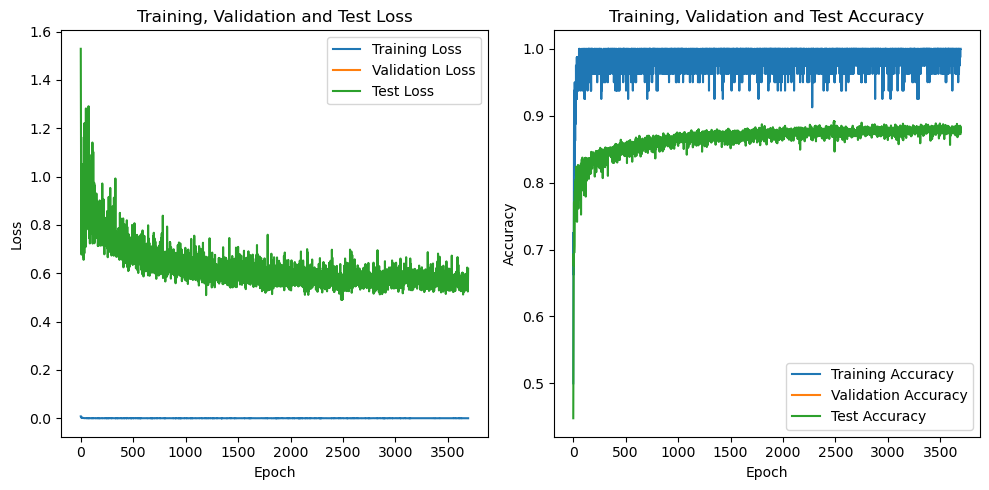

In [50]:
fig, axs = plt.subplots(ncols=2, figsize=(10, 5))

# 첫 번째 그래프: Training and Test Loss
axs[0].plot(logs["train_loss"], label="Training Loss")
axs[0].plot(logs["valid_loss"], label="Validation Loss")
axs[0].plot(logs["test_loss"], label="Test Loss")
axs[0].set_xlabel("Epoch")
axs[0].set_ylabel("Loss")
axs[0].set_title("Training, Validation and Test Loss")
axs[0].legend()

# 두 번째 그래프: Training and Test Accuracy
axs[1].plot(logs["train_acc"], label="Training Accuracy")
axs[1].plot(logs["valid_acc"], label="Validation Accuracy")
axs[1].plot(logs["test_acc"], label="Test Accuracy")
axs[1].set_xlabel("Epoch")
axs[1].set_ylabel("Accuracy")
axs[1].set_title("Training, Validation and Test Accuracy")
axs[1].legend()

# 그래프를 보여줍니다.
plt.tight_layout()
plt.show()

In [51]:
print(len(logs["train_loss"]))
print(len(logs["train_acc"]))
print(len(logs["valid_loss"]))
print(len(logs["valid_acc"]))
print(len(logs["test_loss"]))
print(len(logs["test_acc"]))

3694
3694
0
0
3694
3694


- 주피터노트북 output set
- @tag:notebookOutputLayout